# Exploratory Data Analysis 

TASKS: 
- understand the relationships between historical weather observations and the river gauge levels
- explore the missing values
- lagged variables? 
- visualisations of all above



- What are the patterns (trend, seasonality, cycles) in the river gauge levels and weather data?
- How are the river levels influenced by weather variables over time?
- Are there any lag effects between weather events and river levels?
- What features can be engineered to improve model predictions?

# TODO: 
- write down the data proprocessing steps in order to script the same cleaning for all of the CSVs 
- analyse the time features of the river levels time series alone, the weather data alone, then see how these vary together
- feature engineering and modelling choices

In [1]:
import os
os.chdir('..')

In [2]:


import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import datetime as dt 
import yaml
from src.data_collection import fetch_and_save_river_data, pull_noaa_weather_data, fetch_weather_data_over_years, load_credentials
from src.transform_data import extract_time_values_from_csv, check_missing_days_in_csv
from src.transform_data import remove_negative_river_levels
import os 
import sys

## Plan of attack 
- Initially, we analyse river gauge and weather data separately
- Further, start with a single csv for river data, perform EDA on this
- Key requirements: missing values visualised, percentages 
- Develop code to create an EDA.py script so these functions are easily accesible later in the project: break down into different classes : IE class River, class Weather 
- Can generalise the river EDA to all 30 stations
- Weather data is simpler, we currently have one Cornwall station from NOAA
- After look at the relationships between water levels and weather data



Chose station 1335 randomly, it's Helston Country Bridge

In [5]:
station_1335 = pd.read_csv('./data/river_data/station_1335_clean.csv')

In [6]:
station_1335

,time,value
0,2014-03-04 04:15:00,0.772
1,2014-03-04 04:30:00,0.771
2,2014-03-04 04:45:00,0.771
3,2014-03-04 05:00:00,0.770
4,2014-03-04 05:15:00,0.771
...,...,...
276563,2024-07-11 21:15:00,0.320
276564,2024-07-11 21:45:00,0.318
276565,2024-07-11 22:30:00,0.319
276566,2024-07-11 22:45:00,0.317


In [7]:
station_1335.isnull().sum() # No nulls, but there are gaps in the days


time     0
value    0
dtype: int64

In [8]:
station_1335['time'] = pd.to_datetime(station_1335['time']) # convert to datetime

In [9]:
station_1335.set_index('time', inplace=True)

In [10]:
station_1335

,value
time,
2014-03-04 04:15:00,0.772
2014-03-04 04:30:00,0.771
2014-03-04 04:45:00,0.771
2014-03-04 05:00:00,0.770
2014-03-04 05:15:00,0.771
...,...
2024-07-11 21:15:00,0.320
2024-07-11 21:45:00,0.318
2024-07-11 22:30:00,0.319


In [11]:
station_1335 = station_1335.asfreq('15min')

In [12]:
station_1335

,value
time,
2014-03-04 04:15:00,0.772
2014-03-04 04:30:00,0.771
2014-03-04 04:45:00,0.771
2014-03-04 05:00:00,0.770
2014-03-04 05:15:00,0.771
...,...
2024-07-11 22:45:00,0.317
2024-07-11 23:00:00,NaN
2024-07-11 23:15:00,NaN


In [13]:
# Calculate the percentage of missing values in the 'value' column
missing_percentage = (station_1335['value'].isnull().sum() / len(station_1335)) * 100
print(f"There are {missing_percentage:.2f}% missing measurements in 'value'.")


There are 23.84% missing measurements in 'value'.


In [14]:
station_1335['value'] = station_1335['value'].apply(lambda x: np.nan if x<0 else x) # clean 

In [15]:
station_1335.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363151 entries, 2014-03-04 04:15:00 to 2024-07-11 23:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   276566 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


In [16]:
station_1335.describe()

,value
count,276566.000000
mean,0.482554
std,0.256352
min,0.144000
25%,0.277000
50%,0.415000
75%,0.616000
max,2.044000


<Axes: title={'center': 'Distribution of River Gauge Levels'}, ylabel='Frequency'>

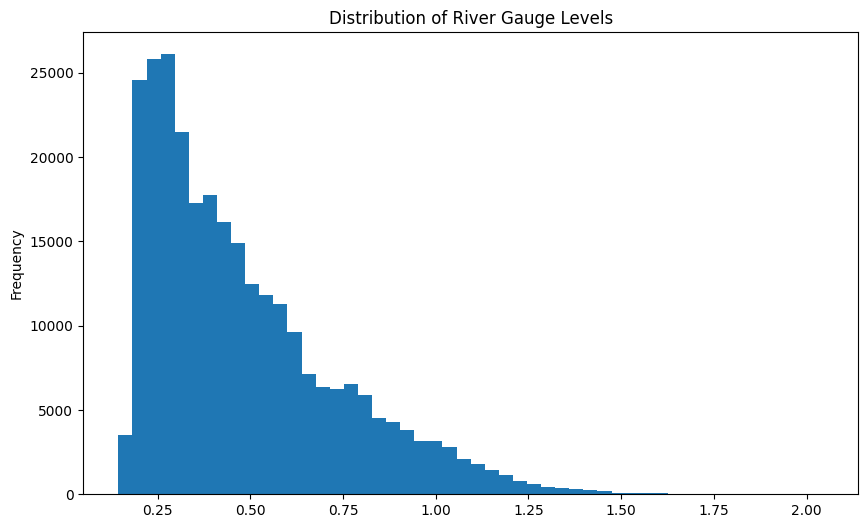

In [17]:
station_1335['value'].plot(kind='hist', bins=50, figsize=(10, 6), title='Distribution of River Gauge Levels')


In [129]:
reasonable_range = station_1335[(station_1335['value'] >= 0) & (station_1335['value'] <= 5)]
unreasonable_values = station_1335[~station_1335.index.isin(reasonable_range.index)]
print(f"Unreasonable values count: {len(unreasonable_values)}")


Unreasonable values count: 86585


In [130]:
station_1335.describe()

,value
count,276566.000000
mean,0.482554
std,0.256352
min,0.144000
25%,0.277000
50%,0.415000
75%,0.616000
max,2.044000


In [18]:
# Extracting time-related features

station_1335['year'] = station_1335.index.year
ten_year_data['month'] = ten_year_data.index.month
ten_year_data.reset_index(inplace=True)
station_1335['week'] = station_1335['time'].dt.isocalendar().week
station_1335['hour'] = station_1335['time'].dt.hour
station_1335['day'] = station_1335['time'].dt.dayofweek
station_1335['day_str'] = station_1335['time'].dt.strftime('%a')
station_1335['year_month'] = station_1335['time'].dt.strftime('%Y_%m')
station_1335.set_index('time', inplace=True)

In [133]:
station_1335.head(5)

,value,year,month,week,hour,day,day_str,year_month
time,,,,,,,,
2014-03-04 04:15:00,0.772,2014,3,10,4,1,Tue,2014_03
2014-03-04 04:30:00,0.771,2014,3,10,4,1,Tue,2014_03
2014-03-04 04:45:00,0.771,2014,3,10,4,1,Tue,2014_03
2014-03-04 05:00:00,0.770,2014,3,10,5,1,Tue,2014_03
2014-03-04 05:15:00,0.771,2014,3,10,5,1,Tue,2014_03


In [19]:
station_1335['value']  = station_1335['value'].interpolate(method='linear')

<Axes: title={'center': 'River Levels Over Time (Station 1335)'}, xlabel='time'>

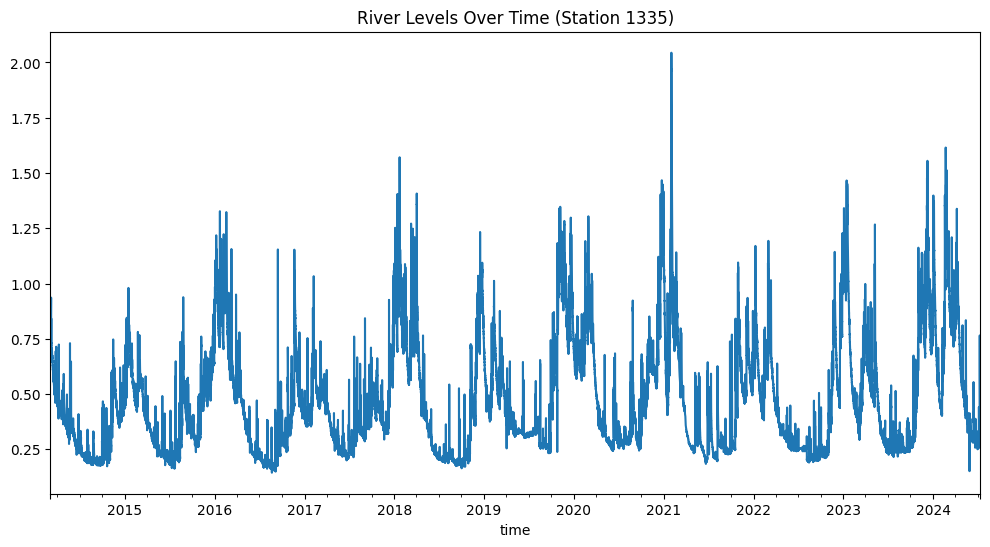

In [20]:
station_1335['value'].plot(figsize=(12, 6), title='River Levels Over Time (Station 1335)') # does work well with nulls, can interpolate (cell above)


In [41]:
station_1335 = station_1335.reset_index()

Seasonality: There are repeating patterns visible, with peaks and troughs occurring fairly regularly. This indicates some level of seasonality, likely related to rainfall or weather conditions.
Anomalies: There are a few periods with very high spikes in river levels, especially in 2019 and early 2020, which could be indicative of extreme weather events or floods.
Trend: It appears that the river levels have consistent fluctuations, without any obvious long-term upward or downward trend, though there might be slight variations over the years.
Range: The river levels seem to range mostly between 0.25 and 1.75 meters, which might indicate typical ranges for the station.

In [ ]:
# What about Boscastle flood in 2004? 

## Exploring Time Features / Time Series Decomposition

### looks like additive decomposition makes sense, given no appearance of trend. 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed for reproducibility
np.random.seed(42)


df_plot = station_1335[['month', 'year', 'value']].groupby(['month', 'year']).mean().unstack('year')

# Renaming columns for clarity
df_plot.columns = df_plot.columns.droplevel()
df_plot.index.name = 'Month'


In [32]:
df_plot

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Month,,,,,,,,,,,
1,NaN,0.647388,0.943407,0.401787,0.957259,0.489557,0.646517,0.768354,0.644624,1.017921,0.735106
2,NaN,0.511136,0.857077,0.569468,0.735145,0.640741,0.787218,0.932639,0.536969,0.468520,0.855934
3,0.594291,0.488122,0.577811,0.501534,0.744213,0.538541,0.764401,0.518432,0.653339,0.521908,0.888348
4,0.444418,0.331979,0.489982,0.369222,0.608819,0.399407,0.392273,0.282274,0.375345,0.627551,0.791409
5,0.357582,0.261693,0.326148,0.267675,0.367016,0.326638,0.306854,0.318759,0.292929,0.528605,0.432971
6,0.285600,0.223004,0.232717,0.244075,0.234413,0.324727,0.312701,0.249847,0.256210,0.289653,0.311972
7,0.225261,0.220794,0.192362,0.274726,0.207282,0.322116,0.286413,0.288104,0.253709,0.260682,0.342102
8,0.205326,0.375546,0.185338,0.350555,0.212848,0.300541,0.345898,0.271932,0.212111,0.263698,NaN
9,0.192685,0.396499,0.272775,0.416869,0.197410,0.288426,0.317549,0.252907,0.222436,0.259911,NaN


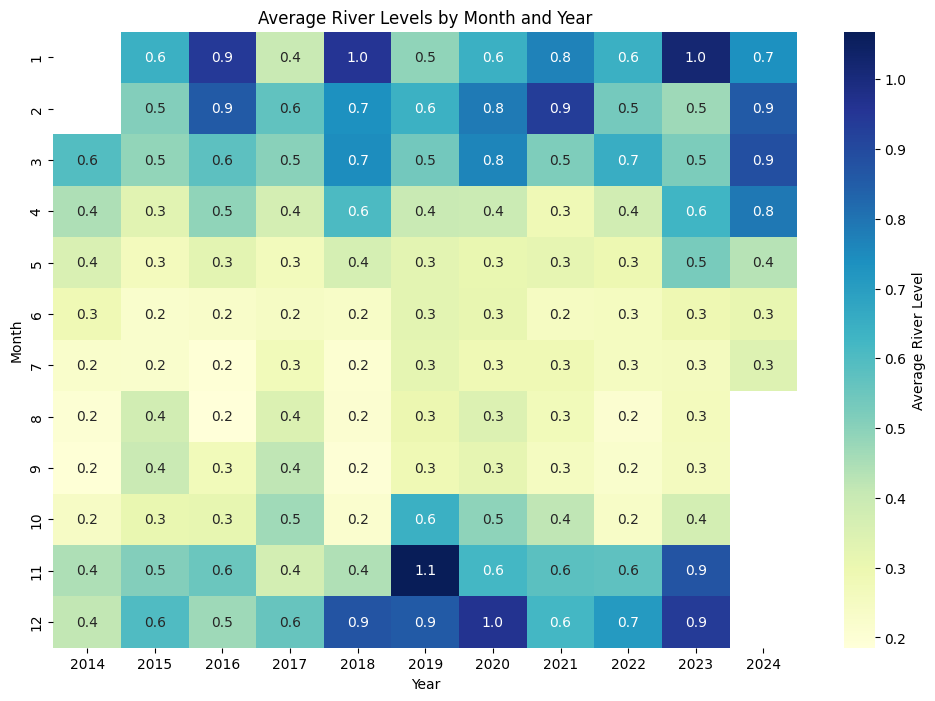

In [31]:
# Set up the figure size and plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_plot, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Average River Level'})
plt.title('Average River Levels by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


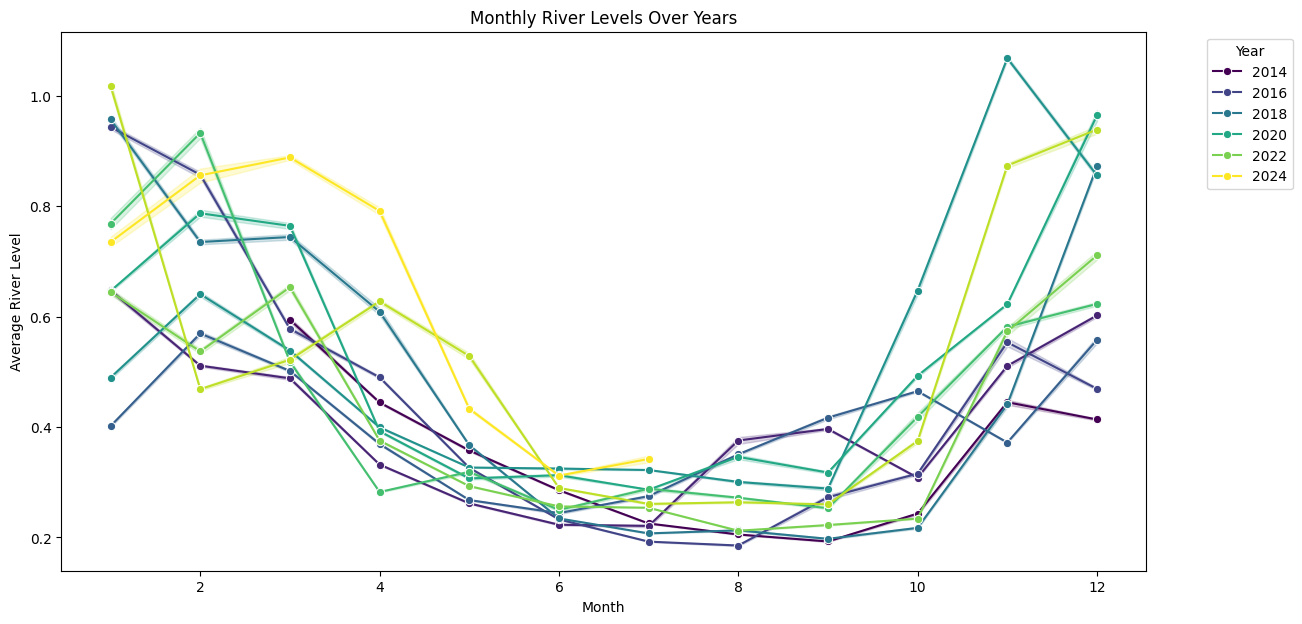

In [33]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=station_1335, x='month', y='value', hue='year', marker='o', palette="viridis")
plt.title('Monthly River Levels Over Years')
plt.xlabel('Month')
plt.ylabel('Average River Level')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


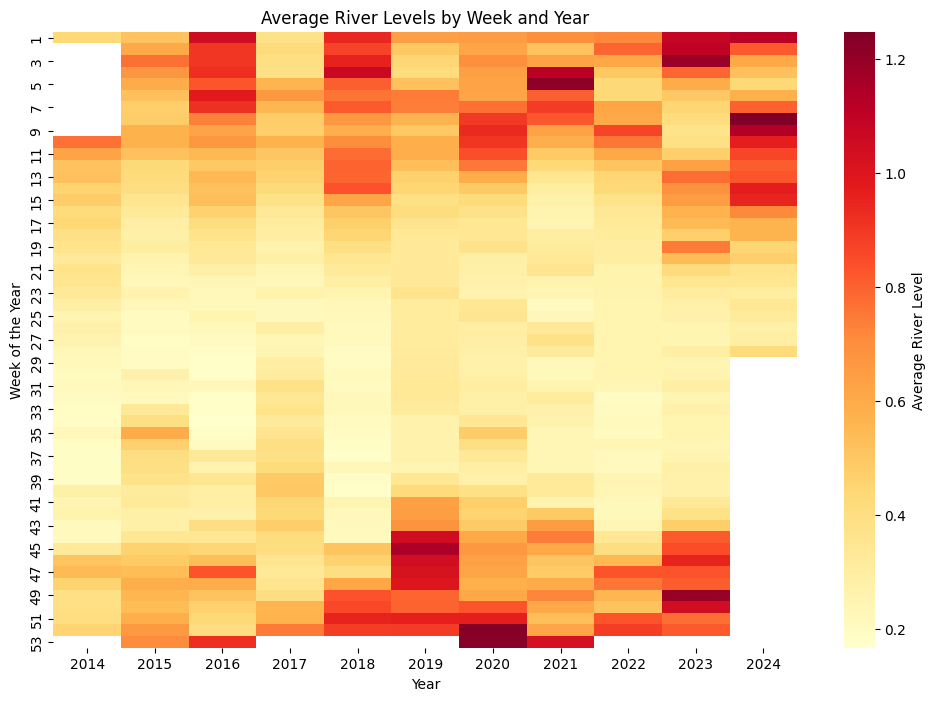

In [34]:
df_weekly = station_1335.groupby(['week', 'year'])['value'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(df_weekly, cmap="YlOrRd", cbar_kws={'label': 'Average River Level'})
plt.title('Average River Levels by Week and Year')
plt.xlabel('Year')
plt.ylabel('Week of the Year')
plt.show()


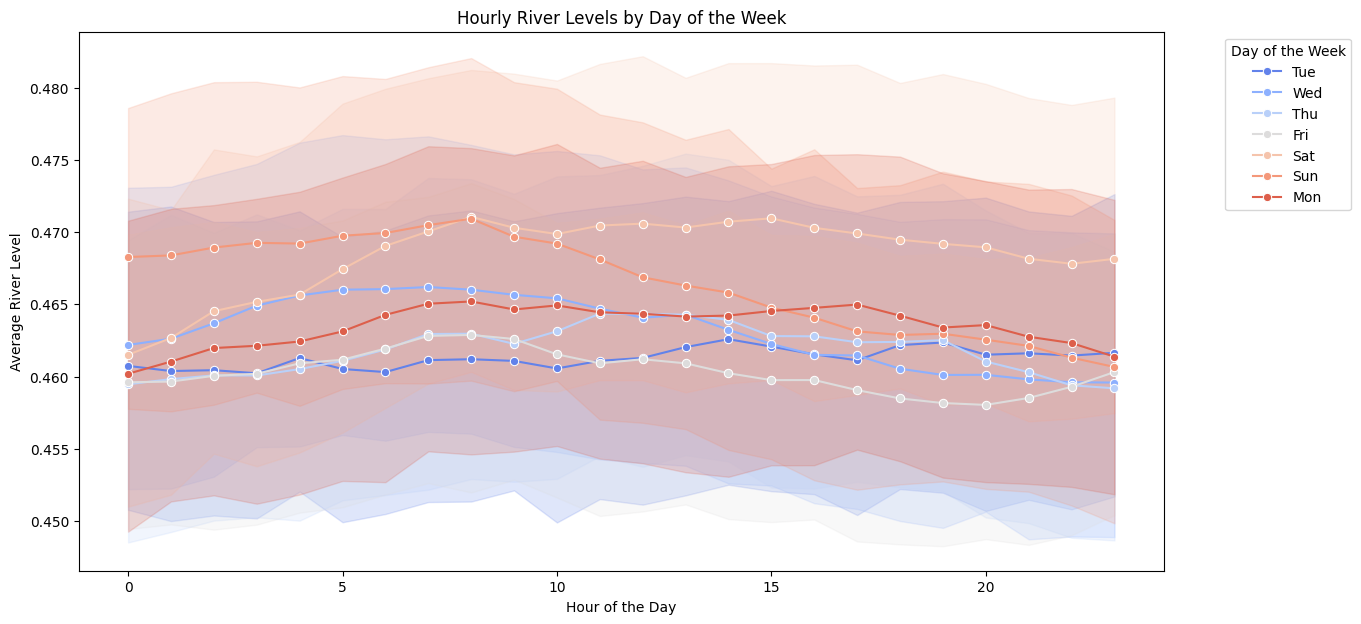

In [35]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=station_1335, x='hour', y='value', hue='day_str', marker='o', palette="coolwarm")
plt.title('Hourly River Levels by Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average River Level')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



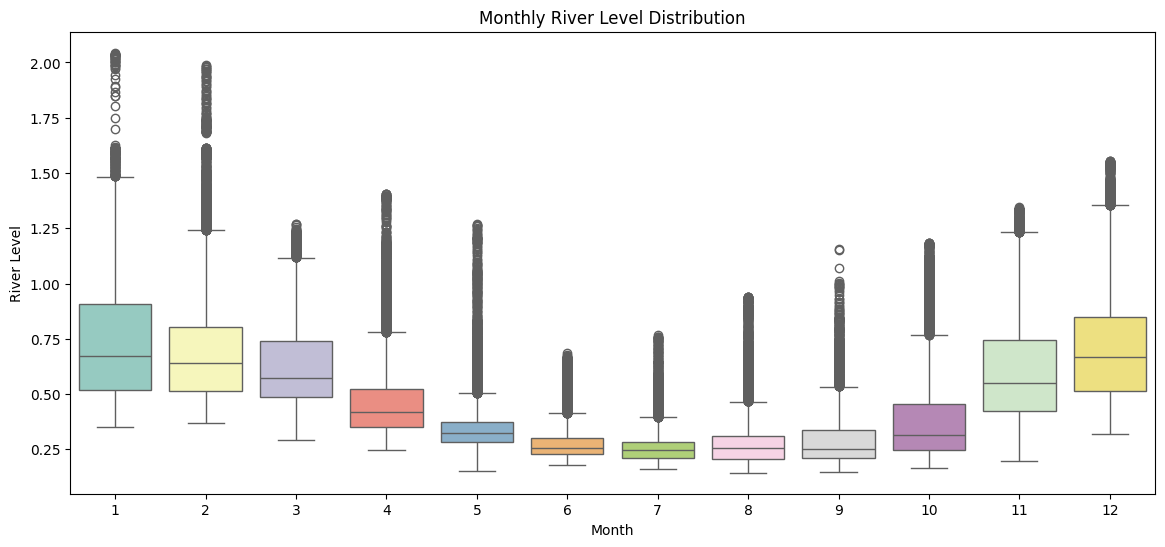


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



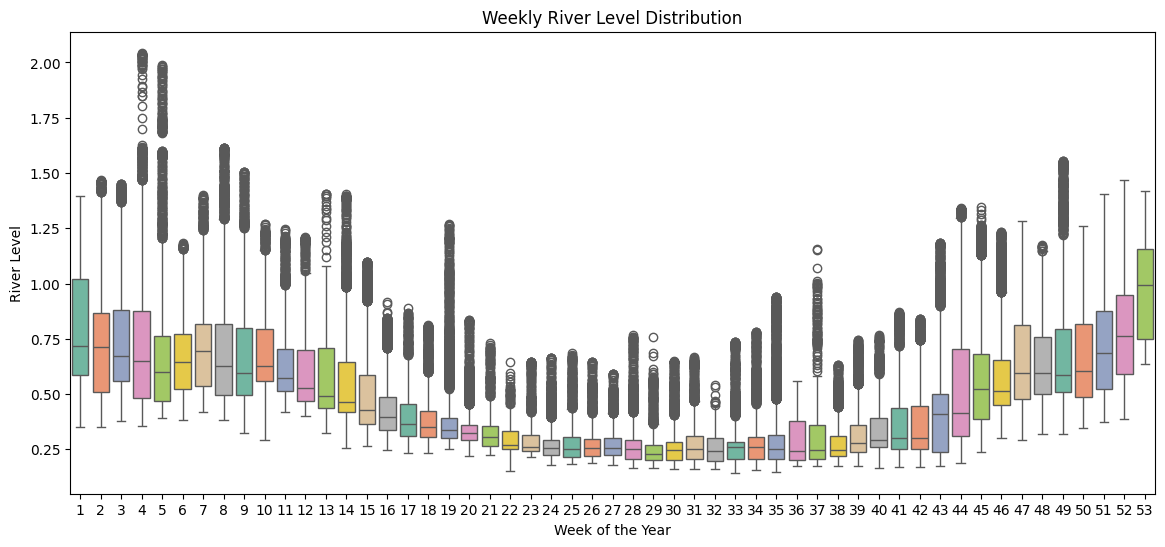

In [37]:
# Box plot by month
plt.figure(figsize=(14, 6))
sns.boxplot(data=station_1335, x='month', y='value', palette="Set3")
plt.title('Monthly River Level Distribution')
plt.xlabel('Month')
plt.ylabel('River Level')
plt.show()

# Box plot by week
plt.figure(figsize=(14, 6))
sns.boxplot(data=station_1335, x='week', y='value', palette="Set2")
plt.title('Weekly River Level Distribution')
plt.xlabel('Week of the Year')
plt.ylabel('River Level')
plt.show()


In [21]:
station_1335['value'].isnull().sum()

np.int64(0)

In [22]:
station_1335.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363151 entries, 2014-03-04 04:15:00 to 2024-07-11 23:45:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   value       363151 non-null  float64
 1   year        363151 non-null  int32  
 2   month       363151 non-null  int32  
 3   week        363151 non-null  UInt32 
 4   hour        363151 non-null  int32  
 5   day         363151 non-null  int32  
 6   day_str     363151 non-null  object 
 7   year_month  363151 non-null  object 
dtypes: UInt32(1), float64(1), int32(4), object(2)
memory usage: 18.4+ MB


In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [64]:
station_1335.isnull().sum()

value    0
dtype: int64

In [24]:
daily_decomposed = seasonal_decompose(station_1335['value'], model='additive', period=96) # daily seasonality? 

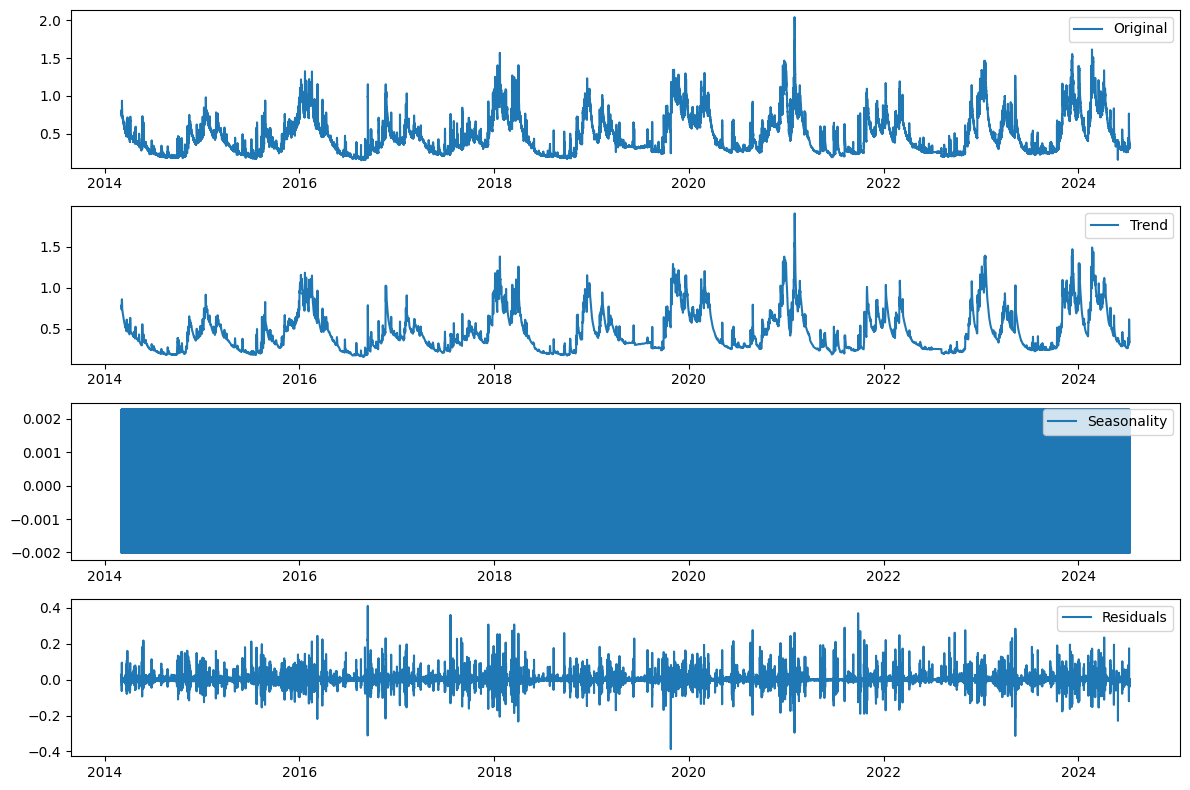

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(daily_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(daily_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(daily_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [26]:
yearly_decomposed = seasonal_decompose(station_1335['value'], model='additive', period=96 * 365) # yearly seasonality? 

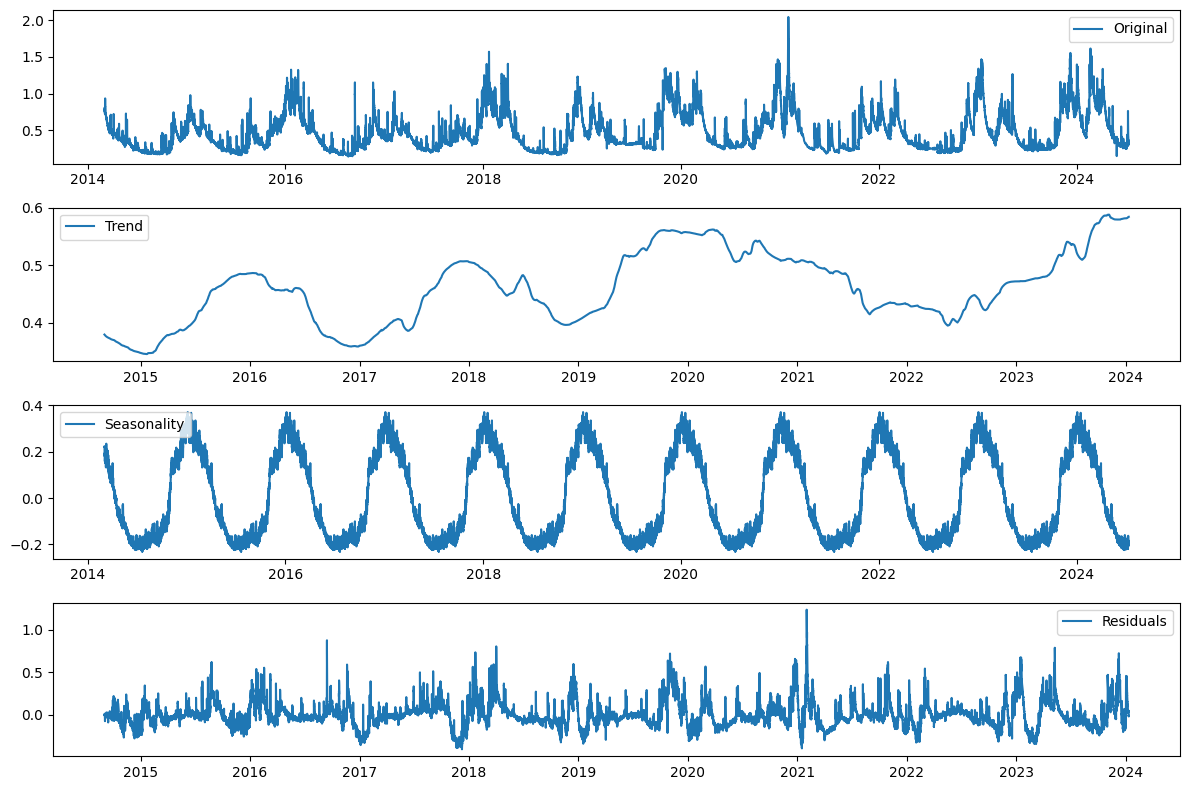

In [27]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(yearly_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(yearly_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(yearly_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [28]:
yearly_mult_decomposed = seasonal_decompose(station_1335['value'], model='multiplicative', period=96 * 365)

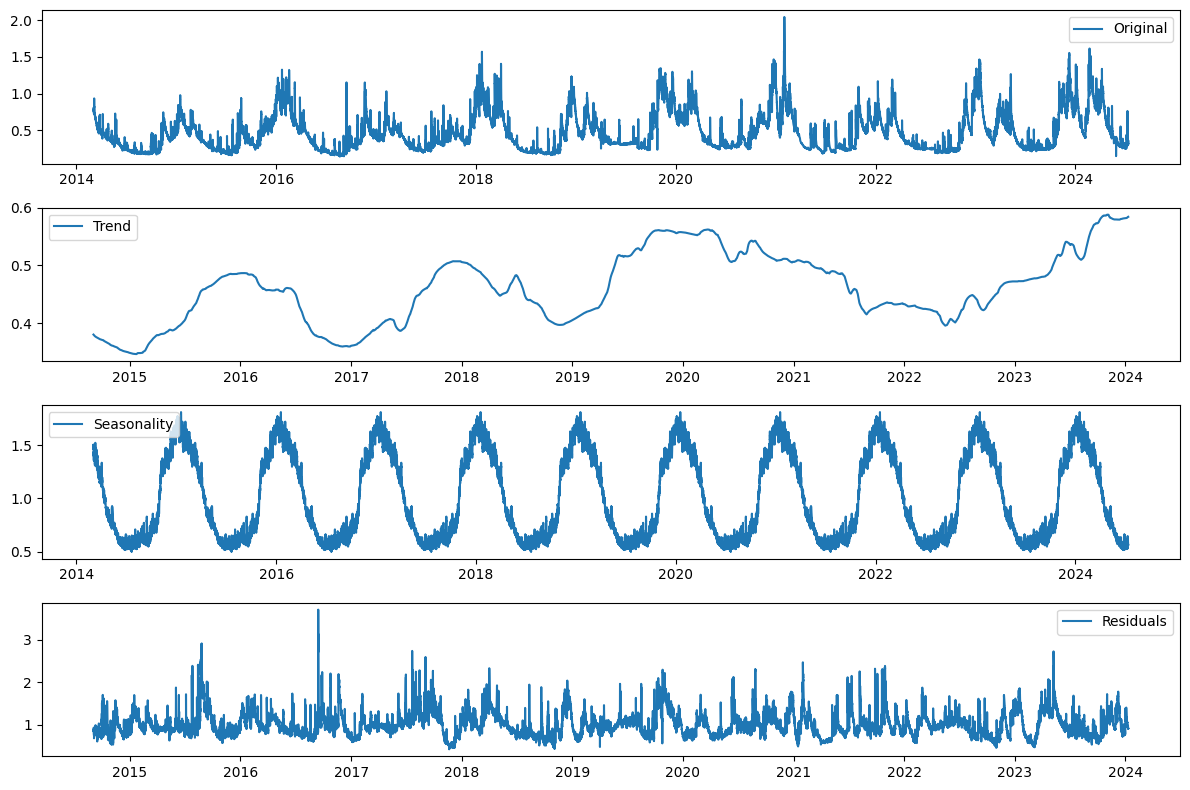

In [29]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(yearly_mult_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(yearly_mult_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(yearly_mult_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

# Weather Data

## Trying a new source

In [ ]:
50.5036° N, 4.6525° W 

In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 50.5036,
	"longitude": -4.6525,
	"start_date": "2024-01-01",
	"end_date": "2024-11-02",
	"hourly": "rain"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_rain = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["rain"] = hourly_rain

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates 50.50966262817383°N -4.611297607421875°E
Elevation 141.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                          date  rain
0    2024-01-01 00:00:00+00:00   0.0
1    2024-01-01 01:00:00+00:00   0.0
2    2024-01-01 02:00:00+00:00   0.0
3    2024-01-01 03:00:00+00:00   0.2
4    2024-01-01 04:00:00+00:00   0.0
...                        ...   ...
7363 2024-11-02 19:00:00+00:00   0.0
7364 2024-11-02 20:00:00+00:00   0.0
7365 2024-11-02 21:00:00+00:00   0.0
7366 2024-11-02 22:00:00+00:00   0.0
7367 2024-11-02 23:00:00+00:00   0.0

[7368 rows x 2 columns]


In [2]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd

current_date = datetime.now()
start_date = current_date - timedelta(days=365 * 10)
data_frames = []

while start_date < current_date:
    # Set end of each chunk to one month after start_date or current date, whichever is earlier
    end_date = min(start_date + relativedelta(months=1), current_date)
    params["start_date"] = start_date.strftime('%Y-%m-%d')
    params["end_date"] = end_date.strftime('%Y-%m-%d')

    # Fetch data and process it
    try:
        responses = openmeteo.weather_api(url, params=params)
        if responses:
            response = responses[0]
            hourly = response.Hourly()
            hourly_rain = hourly.Variables(0).ValuesAsNumpy()
            hourly_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                    freq=pd.Timedelta(seconds=hourly.Interval()),
                    inclusive="left"
                ),
                "rain": hourly_rain
            }
            data_frames.append(pd.DataFrame(data=hourly_data))
    except OpenMeteoRequestsError as e:
        print(f"Error fetching data for {start_date} to {end_date}: {e}")

    # Move to the next month
    start_date = end_date

# Combine all monthly data into a single DataFrame
ten_year_data = pd.concat(data_frames, ignore_index=True)


In [3]:
ten_year_data

,date,rain
0,2014-11-07 00:00:00+00:00,1.6
1,2014-11-07 01:00:00+00:00,0.2
2,2014-11-07 02:00:00+00:00,0.2
3,2014-11-07 03:00:00+00:00,0.4
4,2014-11-07 04:00:00+00:00,0.8
...,...,...
90475,2024-11-04 19:00:00+00:00,NaN
90476,2024-11-04 20:00:00+00:00,NaN
90477,2024-11-04 21:00:00+00:00,NaN
90478,2024-11-04 22:00:00+00:00,NaN


In [96]:
ten_year_data['date'] = pd.to_datetime(ten_year_data['date'])
ten_year_data.set_index('date', inplace=True)

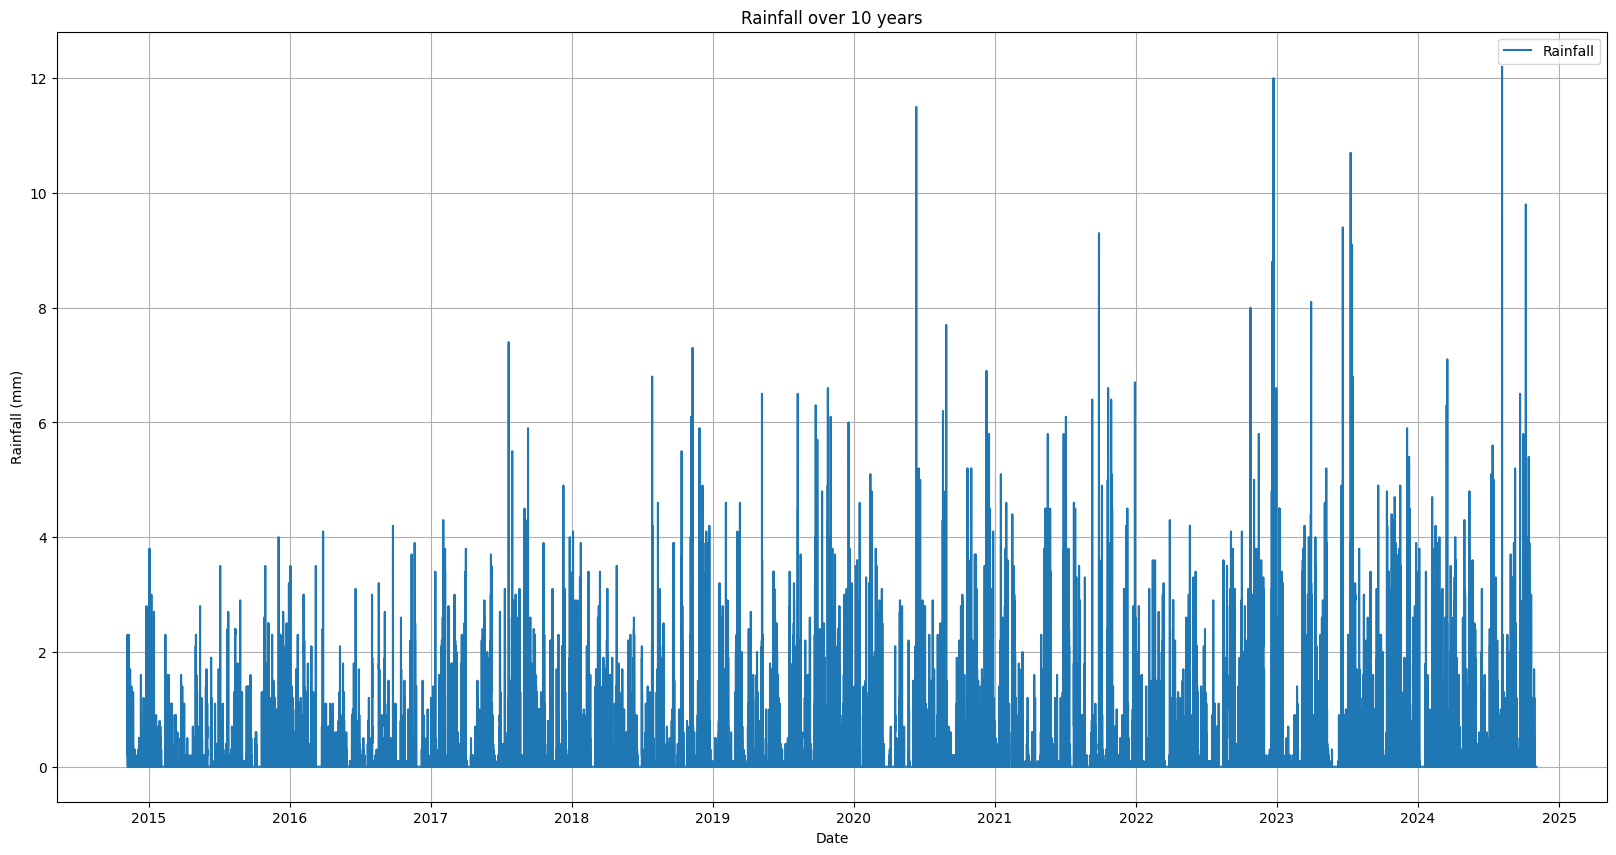

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(ten_year_data.index,ten_year_data['rain'], label = 'Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Rainfall over 10 years')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Extracting time-related features

ten_year_data['year'] = ten_year_data.index.year
ten_year_data['month'] = ten_year_data.index.month
ten_year_data.reset_index(inplace=True)
ten_year_data['week'] = ten_year_data['date'].dt.isocalendar().week
ten_year_data['hour'] = ten_year_data['date'].dt.hour
ten_year_data['day'] = ten_year_data['date'].dt.dayofweek
ten_year_data['day_str'] = ten_year_data['date'].dt.strftime('%a')
ten_year_data['year_month'] = ten_year_data['date'].dt.strftime('%Y_%m')
ten_year_data.set_index('date', inplace=True)

In [98]:
ten_year_data

,rain
date,
2014-11-07 00:00:00+00:00,1.6
2014-11-07 01:00:00+00:00,0.2
2014-11-07 02:00:00+00:00,0.2
2014-11-07 03:00:00+00:00,0.4
2014-11-07 04:00:00+00:00,0.8
...,...
2024-11-04 19:00:00+00:00,NaN
2024-11-04 20:00:00+00:00,NaN
2024-11-04 21:00:00+00:00,NaN


In [39]:
duplicates = ten_year_data.index[ten_year_data.index.duplicated()]
print(duplicates[1])


2014-12-07 01:00:00+00:00


In [40]:
ten_year_data = ten_year_data[~ten_year_data.index.duplicated(keep='first')]


In [41]:
ten_year_data

,rain,year,month,week,hour,day,day_str,year_month
date,,,,,,,,
2014-11-07 00:00:00+00:00,1.6,2014,11,45,0,4,Fri,2014_11
2014-11-07 01:00:00+00:00,0.2,2014,11,45,1,4,Fri,2014_11
2014-11-07 02:00:00+00:00,0.2,2014,11,45,2,4,Fri,2014_11
2014-11-07 03:00:00+00:00,0.4,2014,11,45,3,4,Fri,2014_11
2014-11-07 04:00:00+00:00,0.8,2014,11,45,4,4,Fri,2014_11
...,...,...,...,...,...,...,...,...
2024-11-04 19:00:00+00:00,NaN,2024,11,45,19,0,Mon,2024_11
2024-11-04 20:00:00+00:00,NaN,2024,11,45,20,0,Mon,2024_11
2024-11-04 21:00:00+00:00,NaN,2024,11,45,21,0,Mon,2024_11


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed for reproducibility
np.random.seed(42)


df_plot_rainfall = ten_year_data[['month', 'year', 'rain']].groupby(['month', 'year']).mean().unstack('year')

# Renaming columns for clarity
df_plot_rainfall.columns = df_plot_rainfall.columns.droplevel()
df_plot_rainfall.index.name = 'Month'


In [48]:
df_plot_rainfall

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Month,,,,,,,,,,,
1,NaN,0.133871,0.173253,0.099059,0.217876,0.100000,0.167876,0.241935,0.105108,0.247849,0.161290
2,NaN,0.094643,0.153736,0.142262,0.076488,0.118750,0.392241,0.263839,0.210119,0.035119,0.369253
3,NaN,0.057527,0.104435,0.166398,0.201613,0.212231,0.161156,0.095161,0.121505,0.423656,0.296102
4,NaN,0.019444,0.086389,0.050833,0.172500,0.155000,0.075000,0.023611,0.089722,0.171667,0.250556
5,NaN,0.086022,0.060215,0.110753,0.084140,0.105914,0.039113,0.392473,0.110753,0.105242,0.183602
6,NaN,0.048194,0.118472,0.165278,0.077639,0.203472,0.307222,0.117778,0.128889,0.083750,0.078333
7,NaN,0.102151,0.027688,0.144758,0.115860,0.146640,0.120430,0.240323,0.048118,0.306855,0.193280
8,NaN,0.186290,0.094355,0.126613,0.138575,0.204435,0.248387,0.133065,0.092608,0.186156,0.150269
9,NaN,0.054306,0.092500,0.214444,0.130833,0.262361,0.069028,0.158611,0.215417,0.145417,0.214861


/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_4572/2558206762.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')


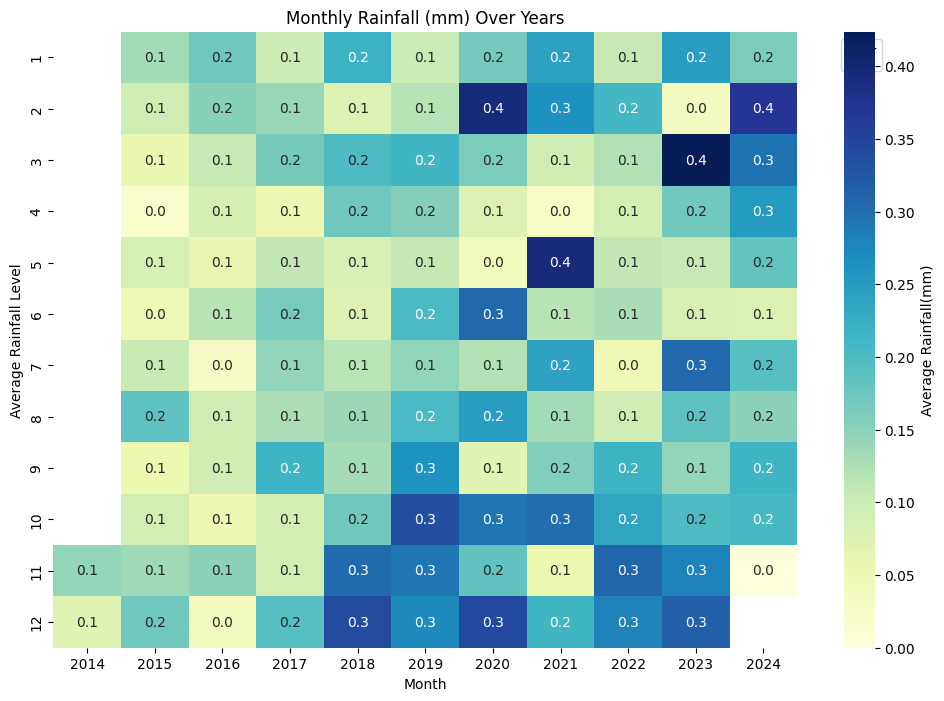

In [44]:
plt.figure(figsize=(12,8))
sns.heatmap(data=df_plot_rainfall,cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Average Rainfall(mm)'})
plt.title('Monthly Rainfall (mm) Over Years')
plt.xlabel('Month')
plt.ylabel('Average Rainfall Level')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [54]:
df_plot_rainfall

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Month,,,,,,,,,,,
1,NaN,0.133871,0.173253,0.099059,0.217876,0.100000,0.167876,0.241935,0.105108,0.247849,0.161290
2,NaN,0.094643,0.153736,0.142262,0.076488,0.118750,0.392241,0.263839,0.210119,0.035119,0.369253
3,NaN,0.057527,0.104435,0.166398,0.201613,0.212231,0.161156,0.095161,0.121505,0.423656,0.296102
4,NaN,0.019444,0.086389,0.050833,0.172500,0.155000,0.075000,0.023611,0.089722,0.171667,0.250556
5,NaN,0.086022,0.060215,0.110753,0.084140,0.105914,0.039113,0.392473,0.110753,0.105242,0.183602
6,NaN,0.048194,0.118472,0.165278,0.077639,0.203472,0.307222,0.117778,0.128889,0.083750,0.078333
7,NaN,0.102151,0.027688,0.144758,0.115860,0.146640,0.120430,0.240323,0.048118,0.306855,0.193280
8,NaN,0.186290,0.094355,0.126613,0.138575,0.204435,0.248387,0.133065,0.092608,0.186156,0.150269
9,NaN,0.054306,0.092500,0.214444,0.130833,0.262361,0.069028,0.158611,0.215417,0.145417,0.214861


In [63]:
ten_year_data.year.value_counts()

year
2016    8784
2020    8784
2015    8760
2017    8760
2018    8760
2019    8760
2021    8760
2022    8760
2023    8760
2024    7416
2014    1320
Name: count, dtype: int64

/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_4572/1930934324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_year_data['year'] = ten_year_data['year'].astype(str)


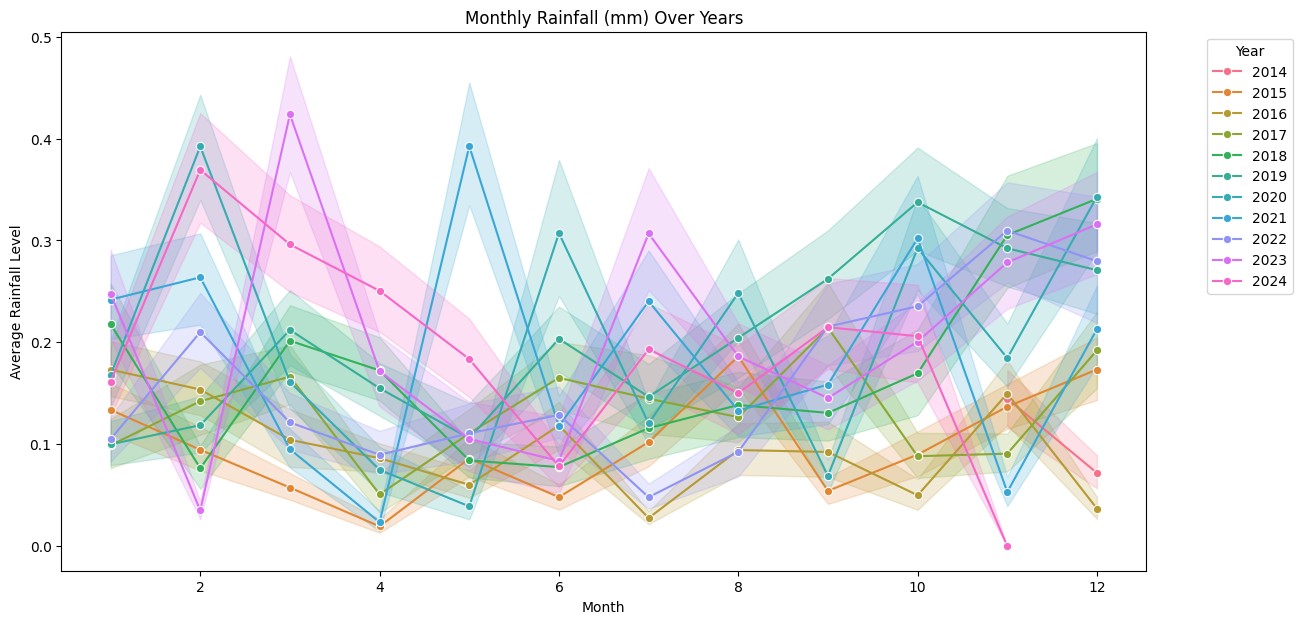

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'year' is treated as a categorical variable
ten_year_data['year'] = ten_year_data['year'].astype(str)

plt.figure(figsize=(14, 7))
sns.lineplot(data=ten_year_data, x='month', y='rain', hue='year', marker='o', palette="husl")
plt.title('Monthly Rainfall (mm) Over Years')
plt.xlabel('Month')
plt.ylabel('Average Rainfall Level')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [108]:
duplicates = ten_year_data.index.duplicated().sum()
print(f"Number of duplicate timestamps: {duplicates}")


Number of duplicate timestamps: 2856


In [107]:
ten_year_data

,rain
date,
2014-11-07 00:00:00+00:00,1.6
2014-11-07 01:00:00+00:00,0.2
2014-11-07 02:00:00+00:00,0.2
2014-11-07 03:00:00+00:00,0.4
2014-11-07 04:00:00+00:00,0.8
...,...
2024-11-04 19:00:00+00:00,0.0
2024-11-04 20:00:00+00:00,0.0
2024-11-04 21:00:00+00:00,0.0


In [111]:
# Confirm the index type and sample values
print(ten_year_data.index)
print(ten_year_data.index.dtype)  # Should be 'datetime64[ns, UTC]' or similar with full timestamp precision



DatetimeIndex(['2014-11-07 00:00:00+00:00', '2014-11-07 01:00:00+00:00',
               '2014-11-07 02:00:00+00:00', '2014-11-07 03:00:00+00:00',
               '2014-11-07 04:00:00+00:00', '2014-11-07 05:00:00+00:00',
               '2014-11-07 06:00:00+00:00', '2014-11-07 07:00:00+00:00',
               '2014-11-07 08:00:00+00:00', '2014-11-07 09:00:00+00:00',
               ...
               '2024-11-04 14:00:00+00:00', '2024-11-04 15:00:00+00:00',
               '2024-11-04 16:00:00+00:00', '2024-11-04 17:00:00+00:00',
               '2024-11-04 18:00:00+00:00', '2024-11-04 19:00:00+00:00',
               '2024-11-04 20:00:00+00:00', '2024-11-04 21:00:00+00:00',
               '2024-11-04 22:00:00+00:00', '2024-11-04 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=90480, freq=None)
datetime64[ns, UTC]


In [112]:
# Check for duplicate timestamps with full timestamp precision
exact_duplicate_timestamps = ten_year_data.index.duplicated().sum()
print(f"Exact duplicate timestamps: {exact_duplicate_timestamps}")


Exact duplicate timestamps: 2856


In [114]:
print(ten_year_data.index.is_unique)  # Should return True if each timestamp is unique



False


In [118]:
seasonal_decompose(ten_year_data, model='additive', period=12)

In [115]:
ten_year_data = ten_year_data[~ten_year_data.index.duplicated(keep='first')]


In [116]:
ten_year_data

,rain
date,
2014-11-07 00:00:00+00:00,1.6
2014-11-07 01:00:00+00:00,0.2
2014-11-07 02:00:00+00:00,0.2
2014-11-07 03:00:00+00:00,0.4
2014-11-07 04:00:00+00:00,0.8
...,...
2024-11-04 19:00:00+00:00,0.0
2024-11-04 20:00:00+00:00,0.0
2024-11-04 21:00:00+00:00,0.0



### daily seasonality of rainfall 

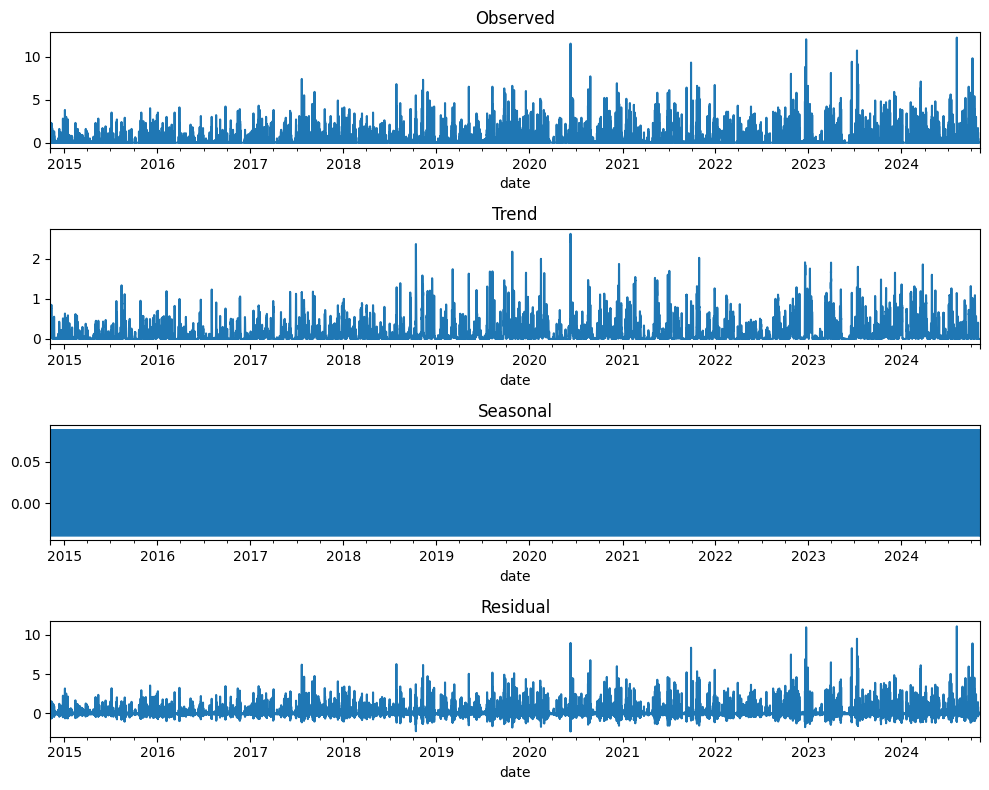

In [ ]:
decomposition = seasonal_decompose(ten_year_data, model='additive', period=24)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')

plt.tight_layout()
plt.show()

### Weekly decomposition of rainfall 

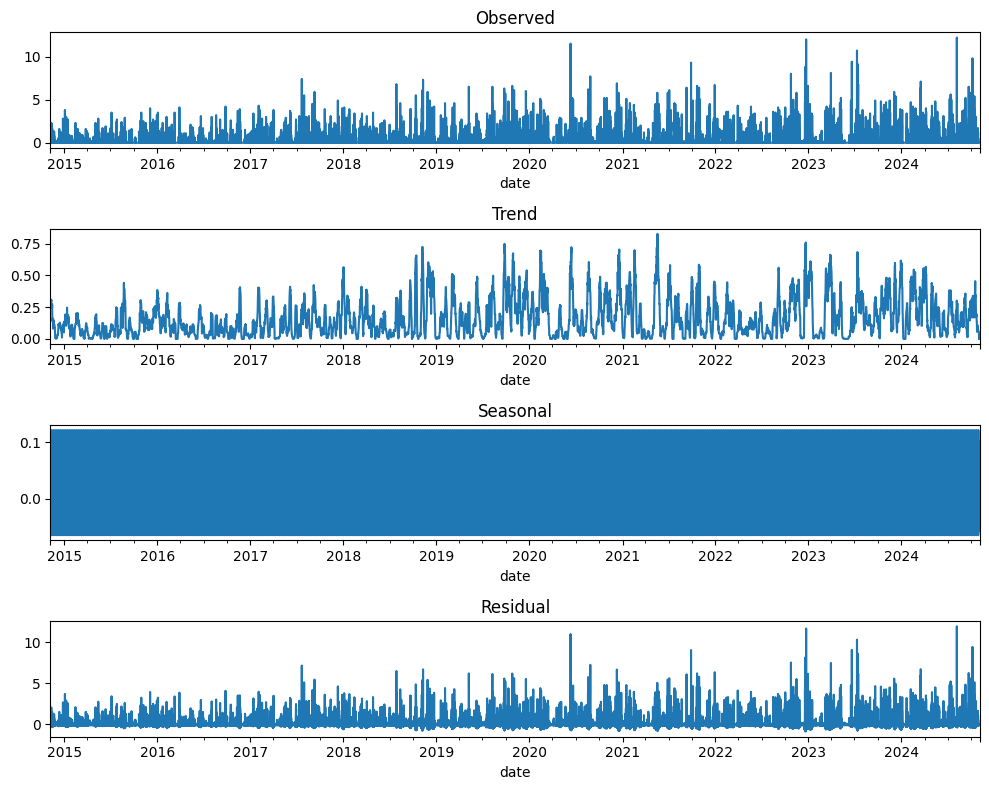

In [124]:
decomposition = seasonal_decompose(ten_year_data, model='additive', period=24* 7)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')

plt.tight_layout()
plt.show()

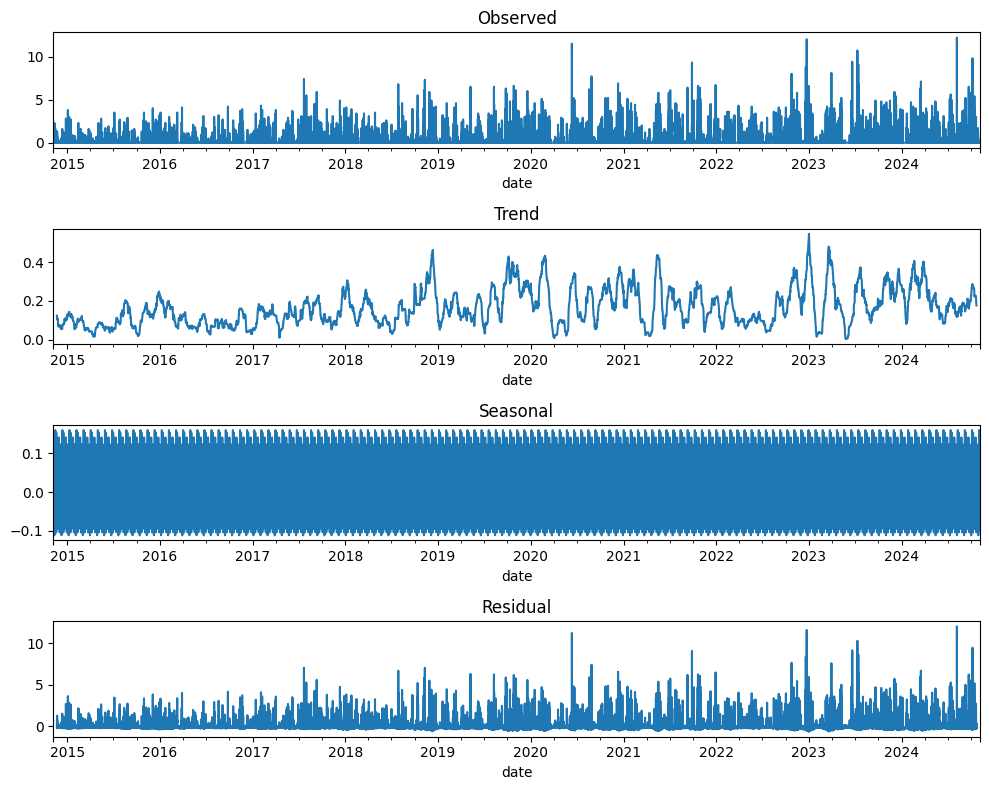

In [125]:
decomposition = seasonal_decompose(ten_year_data, model='additive', period=24* 7 * 4)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')

plt.tight_layout()

/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_13955/2983126545.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_year_data['year'] = ten_year_data.index.year
/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_13955/2983126545.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_year_data['month'] = ten_year_data.index.month
/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_13955/2983126545.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

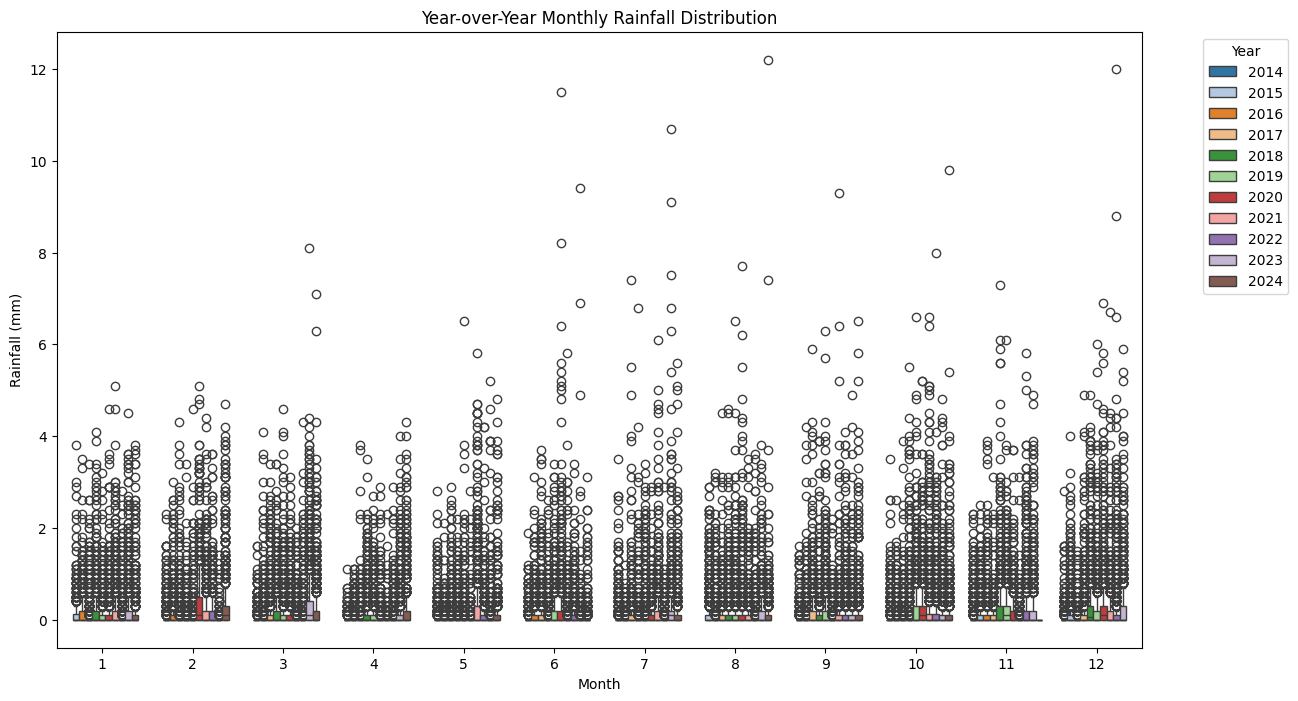

In [4]:
import pandas as pd
ten_year_data['date'] = pd.to_datetime(ten_year_data['date'])
ten_year_data.set_index('date', inplace=True)

ten_year_data = ten_year_data[~ten_year_data.index.duplicated(keep='first')] # drops duplicated timestamp rows, keeping the first instance


# Assuming `ten_year_data` is already loaded with 'date' as index and 'rain' as the rainfall data
ten_year_data['year'] = ten_year_data.index.year
ten_year_data['month'] = ten_year_data.index.month
ten_year_data['week'] = ten_year_data.index.isocalendar().week
ten_year_data['hour'] = ten_year_data.index.hour
ten_year_data['day'] = ten_year_data.index.dayofweek
ten_year_data['day_str'] = ten_year_data.index.strftime('%a')
ten_year_data['year_month'] = ten_year_data.index.strftime('%Y_%m')


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
sns.boxplot(data=ten_year_data, x='month', y='rain', hue='year', palette='tab20')
plt.title('Year-over-Year Monthly Rainfall Distribution')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [15]:
ten_year_data_numeric

date
2014-11-07 00:00:00+00:00    1.6
2014-11-07 01:00:00+00:00    0.2
2014-11-07 02:00:00+00:00    0.2
2014-11-07 03:00:00+00:00    0.4
2014-11-07 04:00:00+00:00    0.8
                            ... 
2024-11-04 19:00:00+00:00    NaN
2024-11-04 20:00:00+00:00    NaN
2024-11-04 21:00:00+00:00    NaN
2024-11-04 22:00:00+00:00    NaN
2024-11-04 23:00:00+00:00    NaN
Name: rain, Length: 87624, dtype: float32

/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_15624/2623751236.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = ten_year_data.resample('M').mean()
/var/folders/4n/18wn5fm9177dpn28hhj4f8w00000gn/T/ipykernel_15624/2623751236.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = ten_year_data.resample('M').mean()


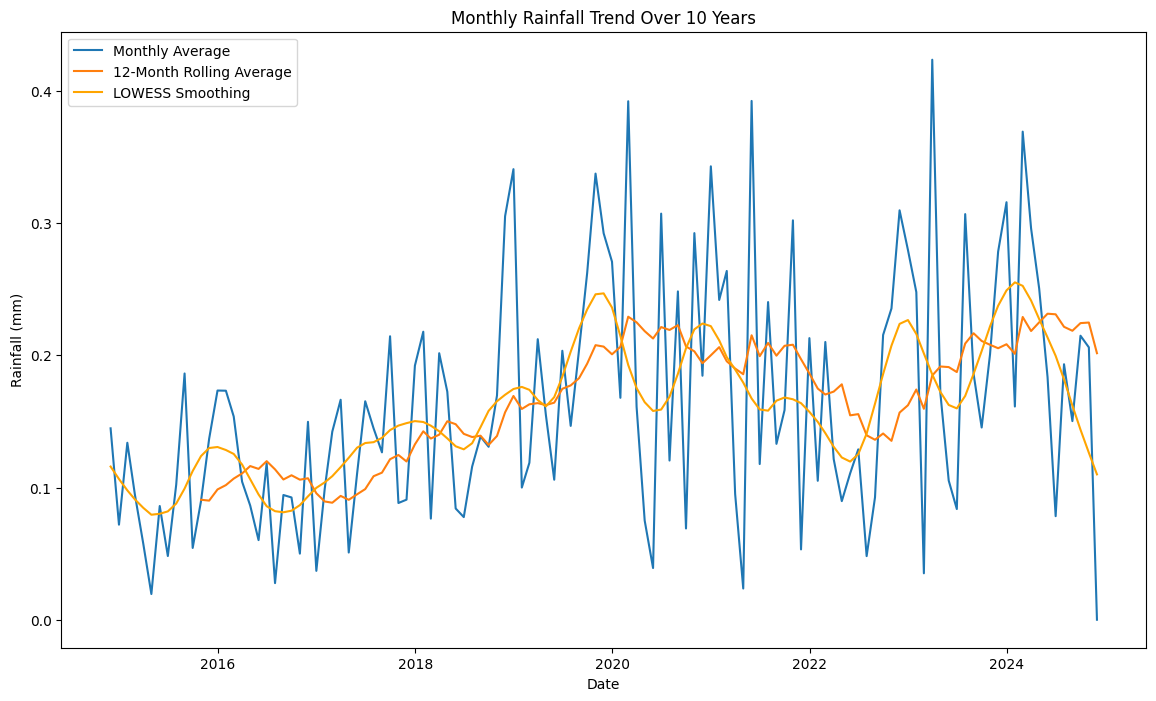

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess


ten_year_data['date'] = pd.to_datetime(ten_year_data['date'])
ten_year_data.set_index('date', inplace=True)

ten_year_data = ten_year_data[~ten_year_data.index.duplicated(keep='first')] # drops duplicated timestamp rows, keeping the first instance

# Select only numeric columns for resampling
# ten_year_data_numeric = ten_year_data.select_dtypes(include=['float64', 'int64'])

# Resample to monthly averages
monthly_data = ten_year_data.resample('M').mean()


# Calculate monthly averages and rolling average on numeric data
monthly_data = ten_year_data.resample('M').mean()
monthly_data['rolling_avg'] = monthly_data['rain'].rolling(window=12).mean()

# Plot the trendline
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_data, x=monthly_data.index, y='rain', label='Monthly Average')
sns.lineplot(data=monthly_data, x=monthly_data.index, y='rolling_avg', label='12-Month Rolling Average')

# Optional: Add LOWESS smoothing
smoothed = lowess(monthly_data['rain'].dropna(), monthly_data.index.dropna(), frac=0.1)
plt.plot(monthly_data.index, smoothed[:, 1], label='LOWESS Smoothing', color='orange')

plt.title('Monthly Rainfall Trend Over 10 Years')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()



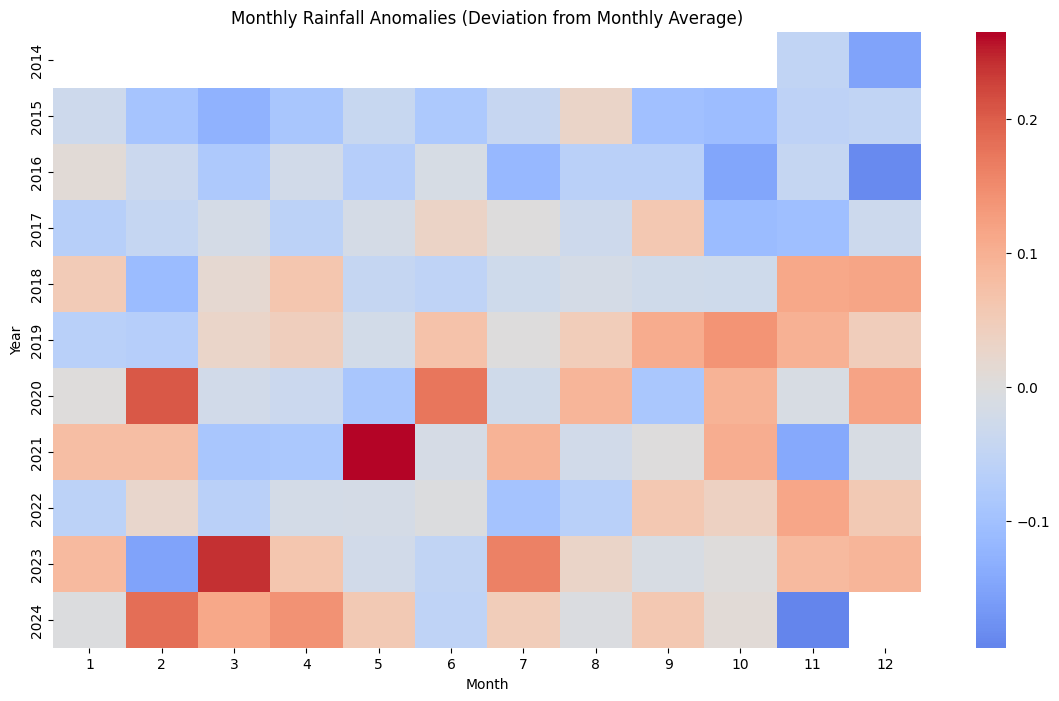

In [5]:
import numpy as np
# Extracting time-related features

ten_year_data['year'] = ten_year_data.index.year
ten_year_data['month'] = ten_year_data.index.month
ten_year_data.reset_index(inplace=True)
ten_year_data['week'] = ten_year_data['date'].dt.isocalendar().week
ten_year_data['hour'] = ten_year_data['date'].dt.hour
ten_year_data['day'] = ten_year_data['date'].dt.dayofweek
ten_year_data['day_str'] = ten_year_data['date'].dt.strftime('%a')
ten_year_data['year_month'] = ten_year_data['date'].dt.strftime('%Y_%m')
ten_year_data.set_index('date', inplace=True)


# Calculate monthly average over all years
monthly_avg = ten_year_data.groupby('month')['rain'].mean()
ten_year_data['rain_anomaly'] = ten_year_data.apply(lambda x: x['rain'] - monthly_avg[x['month']], axis=1)

# Reshape data for heatmap
anomaly_pivot = ten_year_data.pivot_table(index='year', columns='month', values='rain_anomaly')

plt.figure(figsize=(14, 8))
sns.heatmap(anomaly_pivot, cmap='coolwarm', center=0, annot=False, fmt=".1f")
plt.title('Monthly Rainfall Anomalies (Deviation from Monthly Average)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


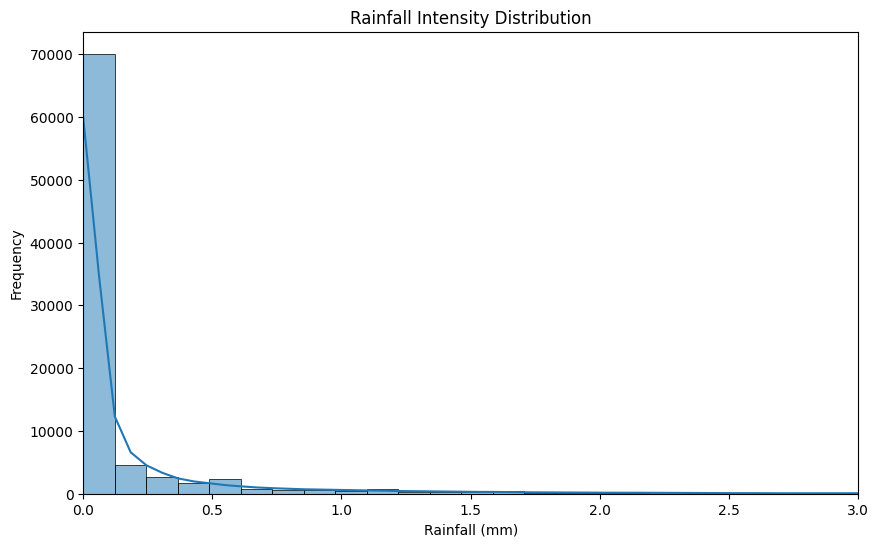

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(ten_year_data['rain'], bins=100, kde=True)
plt.title('Rainfall Intensity Distribution')
plt.xlim(0, 3)
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.show()


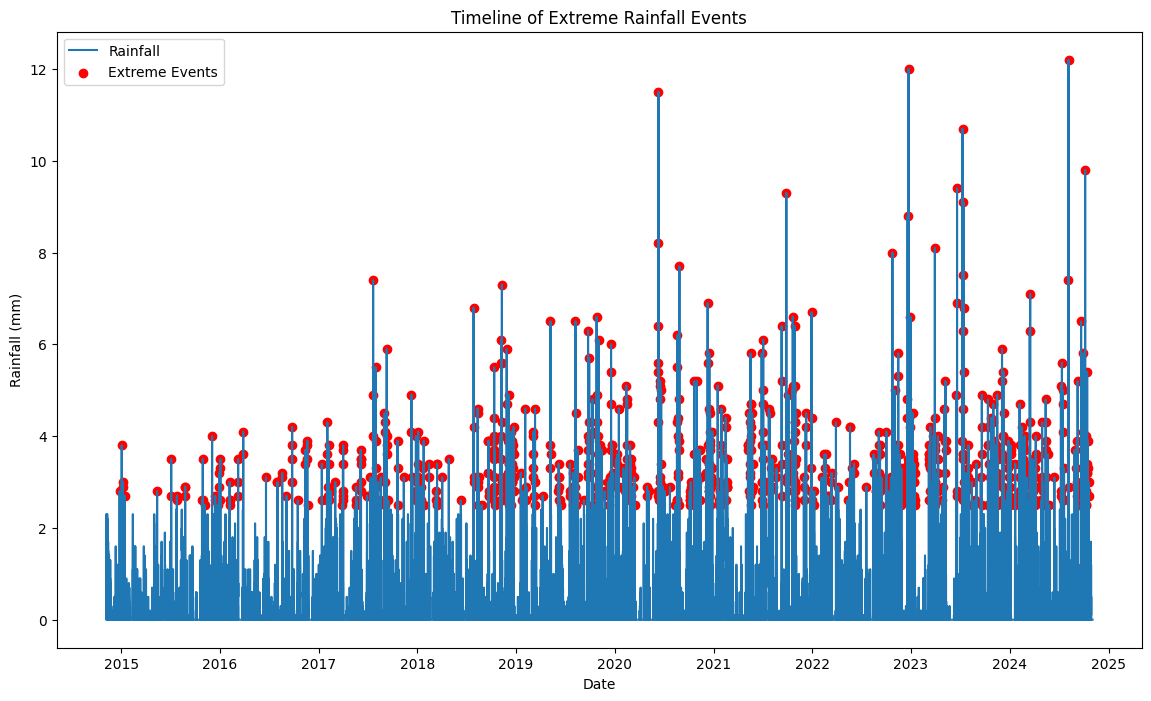

In [ ]:
# Define threshold for extreme events (e.g., top 1%)
threshold = ten_year_data['rain'].quantile(0.99)
extreme_events = ten_year_data[ten_year_data['rain'] >= threshold]

plt.figure(figsize=(14, 8))
sns.lineplot(data=ten_year_data, x='date', y='rain', label='Rainfall')
plt.scatter(extreme_events.index, extreme_events['rain'], color='red', label='Extreme Events')
plt.title('Timeline of Extreme Rainfall Events')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()


## Jointly analyzing rainfall and river level 

In [ ]:
# Assuming 'river_level' is a column in ten_year_data
# Uncomment below line if you have river level data
# plt.figure(figsize=(14, 8))
# sns.scatterplot(data=ten_year_data, x='rain', y='river_level')
# plt.title('Rainfall vs. River Levels')
# plt.xlabel('Rainfall (mm)')
# plt.ylabel('River Level (m)')
# plt.show()

# Calculate correlation with potential lag
# for a hypothetical lag of 24 hours (you can try different lags)
# Uncomment below lines if you have river level data
# correlation = ten_year_data['rain'].rolling(24).corr(ten_year_data['river_level'])
# plt.figure(figsize=(14, 6))
# correlation.plot()
# plt.title('Lagged Correlation between Rainfall and River Levels')
# plt.xlabel('Date')
# plt.ylabel('Correlation')
# plt.show()
